# Efficient Fronteir Portfolio Analysis
## Minimum volatility to minimize risk

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Download historical data as dataframe
tickers = ['AAPL', 'GOOGL', 'META', 'NFLX', 'AMZN', 'CVX', 'OXY', 'MSFT']
start_date = '2020-01-01'
end_date = '2023-01-01'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate returns
returns = data.pct_change()

[*********************100%***********************]  8 of 8 completed


In [12]:
# Define function to calculate portfolio return
def calc_portfolio_return(weights, returns):
    return np.sum(returns.mean() * weights) * 252

# Define function to calculate portfolio variance
def calc_portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

# Define function for constraints (weights must sum to 1)
def check_sum(weights):
    return np.sum(weights) - 1

# Define function to calculate negative Sharpe Ratio (as we'll be minimising this)
def negative_sharpe_ratio(weights, returns, risk_free_rate):
    return -(calc_portfolio_return(weights, returns) - risk_free_rate) / calc_portfolio_volatility(weights, returns)

# Define function to calculate weighted risk-return trade-off
def weighted_risk_return_tradeoff(weights, returns, risk_aversion):
    return calc_portfolio_volatility(weights, returns) + risk_aversion * (1 - calc_portfolio_return(weights, returns))

# Define function to calculate Sharpe Ratio
def calc_sharpe_ratio(weights, returns, risk_free_rate):
    return (calc_portfolio_return(weights, returns) - risk_free_rate) / calc_portfolio_volatility(weights, returns)

# Initial guess for weights
weights_guess = np.array(len(tickers) * [1 / len(tickers)])
bounds = tuple((0, 1) for x in range(len(tickers)))
constraints = ({'type': 'eq', 'fun': check_sum})

In [14]:
# Optimization for max Sharpe Ratio
optimal_weights_sharpe = minimize(negative_sharpe_ratio, weights_guess, args=(returns, 0.01), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimization for min Volatility
optimal_weights = minimize(calc_portfolio_volatility, weights_guess, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)

# Efficient Frontier
num_portfolios = 50000
all_weights = np.zeros((num_portfolios, len(tickers)))
return_array = np.zeros(num_portfolios)
volatility_array = np.zeros(num_portfolios)
sharpe_array = np.zeros(num_portfolios)

for i in range(num_portfolios):
    weights = np.array(np.random.random(len(tickers)))
    weights = weights / np.sum(weights)
    all_weights[i, :] = weights
    return_array[i] = calc_portfolio_return(weights, returns)
    volatility_array[i] = calc_portfolio_volatility(weights, returns)
    sharpe_array[i] = return_array[i] / volatility_array[i]

In [6]:
# Optimization for trade-off point
risk_aversion = 0.5  # Adjust this value to change the trade-off between risk and return
risk_free_rate = 0.01 # Risk free returns for basis offset
tradeoff_weights = minimize(weighted_risk_return_tradeoff, weights_guess, args=(returns, risk_aversion), method='SLSQP', bounds=bounds, constraints=constraints)

# Calculate return, volatility, and Sharpe ratio for trade-off point
tradeoff_return = calc_portfolio_return(tradeoff_weights['x'], returns)
tradeoff_volatility = calc_portfolio_volatility(tradeoff_weights['x'], returns)
tradeoff_sharpe_ratio = (tradeoff_return - risk_free_rate) / tradeoff_volatility

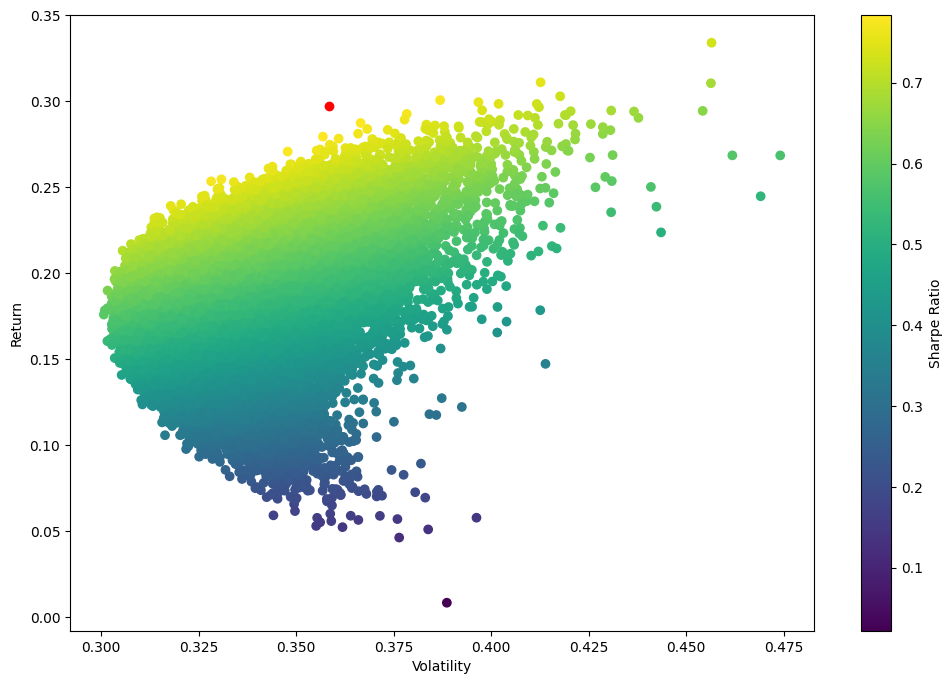

In [17]:
# Plotting the efficient Fronteir Max Sharpe Ratio
# Plotting the efficient frontier
plt.figure(figsize=(12,8))
plt.scatter(volatility_array, return_array, c=sharpe_array, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(calc_portfolio_volatility(optimal_weights_sharpe['x'], returns), calc_portfolio_return(optimal_weights_sharpe['x'], returns), c='red') # red dot
plt.show()

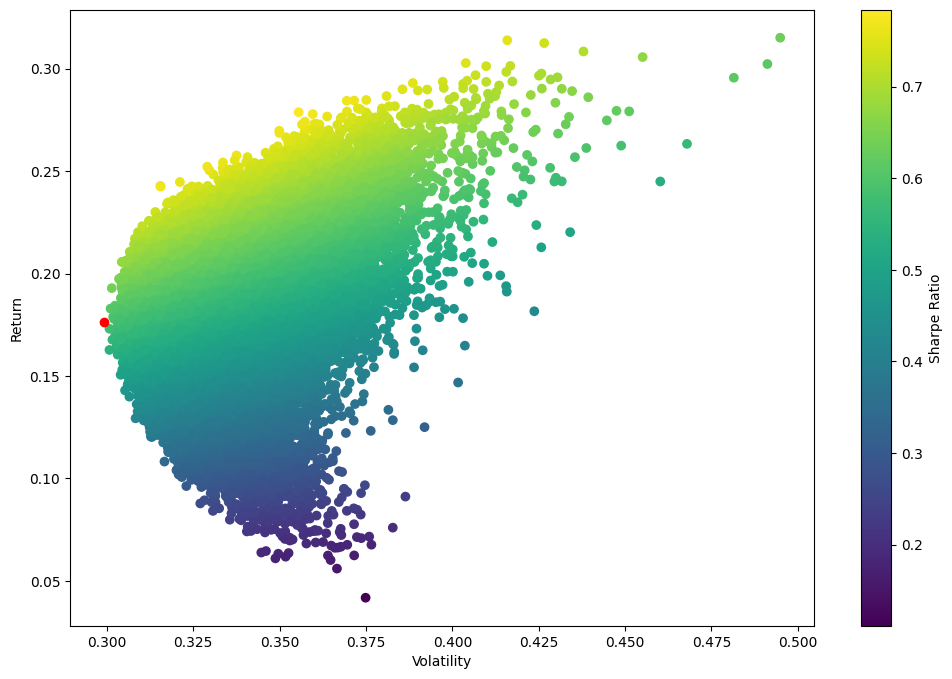

In [7]:
# Plotting the efficient frontier
plt.figure(figsize=(12,8))
plt.scatter(volatility_array, return_array, c=sharpe_array, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(calc_portfolio_volatility(optimal_weights['x'], returns), calc_portfolio_return(optimal_weights['x'], returns), c='red') # red dot
plt.show()

In [8]:
# Print the allocations
print("Minimum Volatility Portfolio Allocation:\n")
for ticker, weight in zip(tickers, optimal_weights['x']):
    print(f"{ticker}: {weight*100:.2f}%")

Minimum Volatility Portfolio Allocation:

AAPL: 10.04%
GOOGL: 20.07%
META: 29.94%
NFLX: 20.96%
AMZN: 0.00%
CVX: 12.88%
OXY: 6.12%
MSFT: 0.00%


In [9]:
# Print the Sharpe ratio at the point of minimum volatility
min_volatility_return = calc_portfolio_return(optimal_weights['x'], returns)
min_volatility = calc_portfolio_volatility(optimal_weights['x'], returns)
risk_free_rate = 0  # Assuming a risk free rate of -11%
sharpe_ratio = calc_sharpe_ratio(optimal_weights['x'], returns, risk_free_rate)
print("Sharpe Ratio at Minimum Volatility Point: ", sharpe_ratio)

Sharpe Ratio at Minimum Volatility Point:  0.5896484028728848


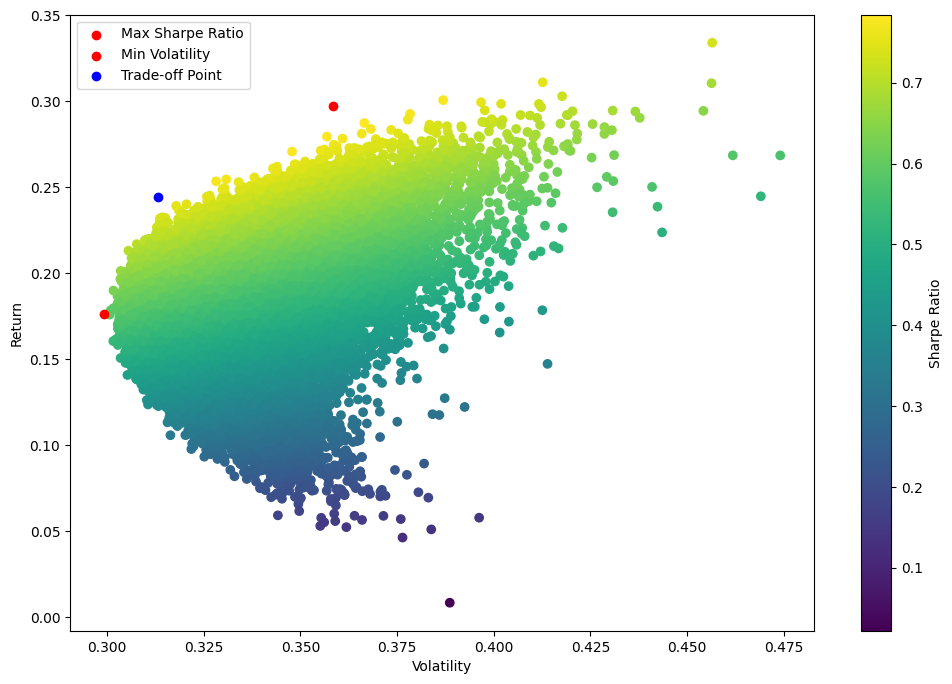

In [19]:
# Plotting the efficient frontier
plt.figure(figsize=(12,8))
plt.scatter(volatility_array, return_array, c=sharpe_array, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(calc_portfolio_volatility(optimal_weights_sharpe['x'], returns), calc_portfolio_return(optimal_weights_sharpe['x'], returns), c='red', label='Max Sharpe Ratio')  # red dot for min volatility
plt.scatter(calc_portfolio_volatility(optimal_weights['x'], returns), calc_portfolio_return(optimal_weights['x'], returns), c='red', label='Min Volatility')  # red dot for min volatility
plt.scatter(calc_portfolio_volatility(tradeoff_weights['x'], returns), calc_portfolio_return(tradeoff_weights['x'], returns), c='blue', label='Trade-off Point')  # blue dot for trade-off point
plt.legend()
plt.show()

In [11]:
# Print the allocations
print("Risk Adjusted Volatility Portfolio Allocation:\n")
for ticker, weight in zip(tickers, tradeoff_weights['x']):
    print(f"{ticker}: {weight*100:.2f}%")

Risk Adjusted Volatility Portfolio Allocation:

AAPL: 38.33%
GOOGL: 0.00%
META: 35.65%
NFLX: 0.00%
AMZN: 0.00%
CVX: 22.61%
OXY: 3.41%
MSFT: 0.00%


In [20]:
!explorer.exe .